In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
import joblib

from sklearn.utils import class_weight

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix 

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

RANDOM_SEED = 42

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_train.shape

(7905, 20)

In [4]:
df_test = pd.read_csv('../data/test.csv')
df_test.shape

(5271, 19)

In [5]:
preprocessing_dict = joblib.load('../pickles/prep_tools.pickle')
preprocessing_dict

{'scaler': StandardScaler(),
 'encoder': OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)}

In [6]:
std_scaler = preprocessing_dict['scaler']
ohe = preprocessing_dict['encoder']

In [7]:
binary_cols = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders']
num_cols = df_train.select_dtypes('number').columns.drop(['id', 'Stage'])
obj_cols = df_train.select_dtypes('object').columns.drop('Status')

In [8]:
def category_generating(X, y = None):
    X['Age_category'] = X.Age.apply(lambda x: 'Old' if x > X.Age.quantile(0.75) else ('Middle' if x <= X.Age.quantile(0.75) and x > X.Age.quantile(0.25) else 'Young'))
    X['N_Days_category'] = X.N_Days.apply(lambda x: 'Many' if x > X.N_Days.quantile(0.75) else ('Middle' if x <= X.N_Days.quantile(0.75) and x > X.N_Days.quantile(0.25) else 'Few'))
    X['Bilirubin_category'] = X.Bilirubin.apply(lambda x: 'High' if x > X.Bilirubin.quantile(0.75) else ('Middle' if x <= X.Bilirubin.quantile(0.75) and x > X.Bilirubin.quantile(0.25) else 'Low'))
    X['Cholesterol_category'] = X.Cholesterol.apply(lambda x: 'High' if x > X.Cholesterol.quantile(0.75) else ('Middle' if x <= X.Cholesterol.quantile(0.75) and x > X.Cholesterol.quantile(0.25) else 'Low'))
    X['Albumin_category'] = X.Albumin.apply(lambda x: 'High' if x > X.Albumin.quantile(0.75) else ('Middle' if x <= X.Albumin.quantile(0.75) and x > X.Albumin.quantile(0.25) else 'Low'))
    X['Copper_category'] = X.Copper.apply(lambda x: 'High' if x > X.Copper.quantile(0.75) else ('Middle' if x <= X.Copper.quantile(0.75) and x > X.Copper.quantile(0.25) else 'Low'))
    X['Alk_Phos_category'] = X.Alk_Phos.apply(lambda x: 'High' if x > X.Alk_Phos.quantile(0.75) else ('Middle' if x <= X.Alk_Phos.quantile(0.75) and x > X.Alk_Phos.quantile(0.25) else 'Low'))
    X['SGOT_category'] = X.SGOT.apply(lambda x: 'High' if x > X.SGOT.quantile(0.75) else ('Middle' if x <= X.SGOT.quantile(0.75) and x > X.SGOT.quantile(0.25) else 'Low'))
    X['Tryglicerides_category'] = X.Tryglicerides.apply(lambda x: 'High' if x > X.Tryglicerides.quantile(0.75) else ('Middle' if x <= X.Tryglicerides.quantile(0.75) and x > X.Tryglicerides.quantile(0.25) else 'Low'))
    X['Platelets_category'] = X.Platelets.apply(lambda x: 'High' if x > X.Platelets.quantile(0.75) else ('Middle' if x <= X.Platelets.quantile(0.75) and x > X.Platelets.quantile(0.25) else 'Low'))
    X['Prothrombin_category'] = X.Prothrombin.apply(lambda x: 'High' if x > X.Prothrombin.quantile(0.75) else ('Middle' if x <= X.Prothrombin.quantile(0.75) and x > X.Prothrombin.quantile(0.25) else 'Low'))

    return X

In [9]:
def columnsBinarising(X, y=None):
    for bin_col in binary_cols:
        X[bin_col] = X[bin_col].apply(lambda x: 1 if x == 'y' or x == 'M' else 0)

    return X

In [10]:
def d_penicillamine_transforming(X, y=None):
    X.Drug = X.Drug.apply(lambda x: 1 if x == 'D-penicillamine' else 0)

    return X

In [11]:
def scaling(X, y=None):
    std_scaled = std_scaler.transform(X[num_cols])
    X[num_cols] = std_scaled

    return X

In [12]:
def encoding(X, y=None):
    cat_cols = X.select_dtypes('object').columns
    cat_cols = np.append(cat_cols, 'Stage')
    ft = ohe.transform(X[cat_cols])
    df_ft = pd.DataFrame(ft, columns=ohe.get_feature_names_out())
    X.reset_index(drop=True, inplace=True)
    df_ft.reset_index(drop=True, inplace=True)
    df_ft = df_ft.astype('int64')
    X = pd.concat([X, df_ft], axis=1)
    X.drop(cat_cols, inplace = True, axis = 1)
    
    return X

In [13]:
preprocessor = Pipeline(
    steps=
    [
        ('categoryGenerator', FunctionTransformer(func=category_generating)),
        ('columnsBinariser', FunctionTransformer(func=columnsBinarising)),
        ('d_penicillamine_transformer', FunctionTransformer(func=d_penicillamine_transforming)),
        ('scaling', FunctionTransformer(func=scaling)),
        ('encoding', FunctionTransformer(func=encoding)),
        
    ]
)

<Axes: >

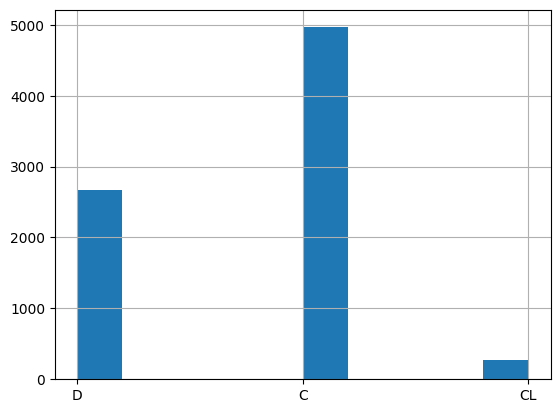

In [78]:
X_train = df_train.drop(['id', 'Status'], axis = 1)
y_train = df_train['Status']

X_test = df_test.drop(['id'], axis = 1)
y_train.hist()

In [79]:
X_train = preprocessor.transform(X_train)
X_train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Edema_N,Edema_S,Edema_Y,Age_category_Middle,Age_category_Old,Age_category_Young,N_Days_category_Few,N_Days_category_Many,N_Days_category_Middle,Bilirubin_category_High,Bilirubin_category_Low,Bilirubin_category_Middle,Cholesterol_category_High,Cholesterol_category_Low,Cholesterol_category_Middle,Albumin_category_High,Albumin_category_Low,Albumin_category_Middle,Copper_category_High,Copper_category_Low,Copper_category_Middle,Alk_Phos_category_High,Alk_Phos_category_Low,Alk_Phos_category_Middle,SGOT_category_High,SGOT_category_Low,SGOT_category_Middle,Tryglicerides_category_High,Tryglicerides_category_Low,Tryglicerides_category_Middle,Platelets_category_High,Platelets_category_Low,Platelets_category_Middle,Prothrombin_category_High,Prothrombin_category_Low,Prothrombin_category_Middle,Stage_1.0,Stage_2.0,Stage_3.0,Stage_4.0
0,-0.942430,1,0.858448,1,0,0,0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0
1,0.497025,0,0.234760,0,0,0,0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0
2,1.277529,0,-1.262634,0,0,0,0,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,0,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1
3,0.498852,0,0.023603,0,0,0,0,-0.523113,-0.484022,-0.139601,-0.341301,-0.086017,-0.887610,-0.368194,0.043117,0.090238,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0
4,-1.135271,0,-0.466107,0,0,0,0,-0.391973,-0.023351,0.293739,-0.275420,-0.333965,0.224347,-0.368194,0.374697,-0.037691,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1


In [80]:
X_test = preprocessor.transform(X_test)

In [81]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y_train = encoder.transform(y_train)
encoded_Y_train

array([2, 0, 2, ..., 2, 2, 0])

In [82]:
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)
dummy_y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, train_size=0.3, shuffle=True, random_state = RANDOM_SEED)

NameError: name 'dummy_y' is not defined

In [83]:
input_count = X_train.shape[1]

In [84]:
# define baseline model
def baseline_model():
 # create model
 model = Sequential()
 model.add(Dense(100, input_dim=input_count, activation='relu'))
 model.add(Dense(100, activation='sigmoid'))
 model.add(Dense(3, activation='softmax'))
 # Compile model
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [85]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1024, verbose=0)

C:\Users\ACER\AppData\Local\Temp\ipykernel_23388\3830666531.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=1024, verbose=0)


In [86]:
kfold = KFold(n_splits=10, shuffle=True)

In [87]:
#results = cross_val_score(estimator, X_train, dummy_y_train, cv=kfold, n_jobs = -1)
results = cross_val_score(estimator, X_train, encoded_Y_train, cv=kfold, n_jobs = -1)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 78.89% (1.75%)


In [88]:
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train  
   )
class_weights = dict(enumerate(class_weights))

In [89]:
estimator.fit(X_train, encoded_Y_train,
             batch_size=1024,
              epochs=3,
              class_weight=class_weights,
              shuffle=True
             )

In [90]:
pred_train = estimator.predict(X_train)
pred_train

248/248 [==============================] - 0s 532us/step


array([2, 0, 2, ..., 2, 0, 0])

In [91]:
pred_test = estimator.predict(X_test)
pred_test

165/165 [==============================] - 0s 609us/step


array([0, 1, 2, ..., 0, 0, 2])

In [92]:
probs = estimator.predict_proba(X_test)
probs

165/165 [==============================] - 0s 628us/step


array([[0.5269994 , 0.26746747, 0.20553307],
       [0.3440973 , 0.45457426, 0.20132846],
       [0.26246056, 0.32202235, 0.41551706],
       ...,
       [0.6022716 , 0.23673002, 0.16099837],
       [0.42416188, 0.4149295 , 0.16090862],
       [0.31282833, 0.2174932 , 0.4696785 ]], dtype=float32)

In [35]:
#roc_auc_score(pred_train, y_train)

In [93]:
estimator.classes_

array([0, 1, 2])

In [37]:
result_df = pd.DataFrame(probs)
result_df = result_df.rename({result_df.columns[0]: 'Status_' + estimator.classes_[0], result_df.columns[1]: 'Status_' + estimator.classes_[1], result_df.columns[2]: 'Status_' + estimator.classes_[2]}, axis=1)
result_df['id'] = df_test.id
result_df = result_df[['id', 'Status_C', 'Status_CL', 'Status_D']]
result_df

,id,Status_C,Status_CL,Status_D
0,7905,0.366408,0.308692,0.324901
1,7906,0.315069,0.484544,0.200387
2,7907,0.237131,0.265584,0.497285
3,7908,0.566847,0.269424,0.163729
4,7909,0.312091,0.376660,0.311249
...,...,...,...,...
5266,13171,0.375035,0.363990,0.260975
5267,13172,0.536661,0.257455,0.205884
5268,13173,0.512657,0.274269,0.213075
5269,13174,0.514387,0.333366,0.152247


In [32]:
result_df.to_csv('../data/result_3.csv', index = False)

In [249]:
X = df_train.drop(['id', 'Status'], axis = 1)
y = df_train['Status']
y = y.apply(lambda x: 0 if x == 'C' else (1 if x == 'D' else 2))
y = y.astype('int64')

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, shuffle=True, random_state = RANDOM_SEED)

In [251]:
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [252]:
# define baseline model
def baseline_model():
 # create model
 model = Sequential()
 model.add(Dense(448, input_dim=input_count, activation='gelu'))
 model.add(Dense(32, activation='exponential'))
 model.add(Dense(3, activation='softmax'))
 # Compile model
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [253]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=1000, batch_size=1024, verbose=0)

C:\Users\ACER\AppData\Local\Temp\ipykernel_23388\3810148743.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=1000, batch_size=1024, verbose=0)


In [254]:
import keras_tuner

In [255]:
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train  
   )
class_weights = dict(enumerate(class_weights))

estimator.fit(X_train, y_train,
              batch_size=1024,
              epochs=3,
              class_weight=class_weights,
              #validation_data=(X_test, y_test),
              shuffle=True)

In [256]:
#estimator.fit(X_train, y_train)

In [257]:
probs = estimator.predict_proba(X_test)
probs

173/173 [==============================] - 0s 701us/step


array([[0.55003655, 0.19396739, 0.25599605],
       [0.332969  , 0.334375  , 0.332656  ],
       [0.8309724 , 0.07121066, 0.09781692],
       ...,
       [0.5232333 , 0.14362024, 0.33314648],
       [0.65113556, 0.15245351, 0.19641092],
       [0.8561229 , 0.06973161, 0.07414549]], dtype=float32)

In [258]:
pred_test = estimator.predict(X_test)
pred_test

173/173 [==============================] - 0s 769us/step


array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [259]:
roc_auc_score(y_test, probs, multi_class = 'ovr')

0.8288045079572058

In [234]:
y_pred_train = estimator.predict(X_train)
y_pred_test =estimator.predict(X_test)
y_pred_prob_test = estimator.predict_proba(X_test) 
accuracy_score_test = accuracy_score(y_test, y_pred_test)
accuracy_score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test, average='micro')
precision_test = precision_score(y_test, y_pred_test, average='micro')
recall_test = recall_score(y_test, y_pred_test, average='micro')
roc_auc_test = roc_auc_score(y_test, y_pred_prob_test, multi_class='ovr')

print(f'Модель: {type(estimator).__name__}\nAccuracy_test: {accuracy_score_test}\nf1 score: {f1_test}\nPrecision: {precision_test}\nRecall: {recall_test}\nROC_AUC: {roc_auc_test}\n')

173/173 [==============================] - 0s 960us/step
Модель: KerasClassifier
Accuracy_test: 0.5811348030357788
f1 score: 0.5811348030357788
Precision: 0.5811348030357788
Recall: 0.5811348030357788
ROC_AUC: 0.7998576282877227



In [188]:
from tensorflow.keras import layers

In [ ]:
def baseline_model():
 # create model
 model = Sequential()
 model.add(Dense(100, input_dim=input_count, activation='relu'))
 model.add(Dense(100, activation='sigmoid'))
 model.add(Dense(3, activation='softmax'))
 # Compile model
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

In [241]:
def build_model(hp):
    model = Sequential()
    model.add(layers.Flatten())
        
    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units1", min_value=32, max_value=512, step=32),
            input_dim=input_count,
            activation=hp.Choice("activation1", ["relu", "tanh", 'sigmoid', 'selu', 'elu', 'exponential', 'leaky_relu', 'relu6 ', 'silu', 'gelu', 'hard_sigmoid', 'linear', 'mish', 'log_softmax']),
        )
    )

    model.add(
        layers.Dense(
            # Define the hyperparameter.
            units=hp.Int("units2", min_value=32, max_value=512, step=32),
            activation=hp.Choice("activation2", ["relu", "tanh", 'sigmoid', 'selu', 'elu', 'exponential', 'leaky_relu', 'relu6 ', 'silu', 'gelu', 'hard_sigmoid', 'linear', 'mish', 'log_softmax']),
        
        )
    )
    
    model.add(layers.Dense(3, activation="softmax"))
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
    )
    return model

In [242]:
build_model(keras_tuner.HyperParameters())

In [243]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [244]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'selu', 'elu', 'exponential', 'leaky_relu', 'relu6 ', 'silu', 'gelu', 'hard_sigmoid', 'linear', 'mish', 'log_softmax'], 'ordered': False}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'selu', 'elu', 'exponential', 'leaky_relu', 'relu6 ', 'silu', 'gelu', 'hard_sigmoid', 'linear', 'mish', 'log_softmax'], 'ordered': False}


In [245]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

Trial 3 Complete [00h 00m 03s]
val_accuracy: 0.8033971786499023

Best val_accuracy So Far: 0.8047524392604828
Total elapsed time: 00h 00m 06s


In [247]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')}, {best_hps.get('units2')}, {best_hps.get('activation1')}, {best_hps.get('activation2')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448, 32, gelu, exponential.



In [212]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]

# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 28, 28))
best_model.summary()